https://developers.google.com/optimization/assignment/assignment_example 와 재연학생이 짠 코드를 참고하여 만들었습니다.  


# 배치

#### 0. 패키지 및 데이터 불러오기

In [1]:
###import packages 
import pandas as pd
import numpy as np
import osmnx as ox
import itertools
import warnings 
import polyline
import requests
import json
import math
from shapely.geometry import Point
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from ortools.linear_solver import pywraplp
from IPython.display import clear_output
import matplotlib.pyplot as plt
from itertools import repeat
from tqdm import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
###Data load
taxi_locations = pd.read_pickle('data/taxi_locations.pkl')
passenger_locations = pd.read_pickle('data/passenger_locations.pkl')

---
### 01. 전처리

**전처리 과정**
1. 차량 분류 (휠체어 불가능 차량: 0, 가능 차량: 1)
2. 차량 ID 변경 (ID -> 0~N)
3. 고객 타입 임의 부여 (0: 휠체어X, 1: 휠체어)
4. 시간 단위 변경 (시분초 -> 분 (0~1440분))
5. 승객 route, timestamp 추가
6. 택시 고유 ID 별 첫 운행 시작 시간 추출 (운행 시작 시간 유추를 위함)
7. 택시 근무시간 고려 출퇴근시간 임의 지정
8. 승객 데이터, 택시 데이터 컬럼명 재정의 및 필요 컬럼 추가 (추후 혼동 방지)


cf.
> 차량 타입 = 대형승용, 중형승용(개인택시) : 0(비휠체어), 중형승합 : 1(휠체어)

> 고객 타입 = 0(비휠체어 20%), 1(휄체어80%) 

In [3]:
### 1. 차량 분류 변경 -> 휠체어 탑승 불가능 : 0, 휠체어 탑습 가능 : 1 
def cartype_transform(ps_loc_data):
    cartype_dict = {"대형승용": 0, "중형승용": 0, "증형승용": 0, "중형승합": 1}

    ps_loc_data["cartype"] = list(map(lambda data: data.replace(" ", ""), ps_loc_data.cartype))
    ps_loc_data["cartype"] = [cartype_dict[i] for i in ps_loc_data.cartype]
    return ps_loc_data

### 2. 차량 ID 변경 0~547
def change_taxi_id(ps_loc_data):
    change_ID = {i:idx for idx,i in enumerate(set(ps_loc_data.no))}

    ps_loc_data["no"] = [change_ID[i] for i in ps_loc_data["no"]]
    return ps_loc_data

### 3. 고객 타입 임의 부여 (0 : 비휠체어, 1 : 휠체어)
def add_passenger_type(ps_loc_data):
    np.random.seed(1205)
    passenger_type_data = np.random.choice(2 ,size = len(ps_loc_data), p=[0.2, 0.8])
    ps_loc_data["passenger_type"] = passenger_type_data
    return ps_loc_data

### 4. 시간 단위 변환 함수 (0~1440분) 
# - 배차는 매 분마다 수행이 되도록
# - 매초단위로 수행할 경우 최적화를 돌리는게 큰 의미가 없음
def time_transform(ps_loc_data):
    #사용하는 컬럼만 copy
    passenger_df = ps_loc_data[['no', 
                                'cartype',
                                'passenger_type',
                                'settime_date',
                                'settime_time',
                                'receipttime_date',
                                'receipttime_time',
                                'start_point',
                                'end_point',
                                "adm_nm_start",
                                "adm_nm_end"]].copy()
    
    #택시가 콜 수락한 시간
    settime_date = pd.to_datetime(passenger_df["settime_date"], format = '%Y-%m-%d')
    settime_date = list(map(lambda data: data.day, settime_date))
    settime_time = pd.to_datetime(passenger_df['settime_time'], format='%H:%M:%S')
    
    #고객 콜 접수 시간
    receipttime_date = pd.to_datetime(passenger_df['receipttime_date'], format='%Y-%m-%d')
    receipttime_date = list(map(lambda data: data.day, receipttime_date))
    receipttime_time = pd.to_datetime(passenger_df['receipttime_time'], format='%H:%M:%S')
    
    #시분초 -> 0~1440분으로 변환
    set_time = settime_time.dt.minute + settime_time.dt.hour*60
    set_time = set_time.tolist()
    
    receipt_time = receipttime_time.dt.minute + receipttime_time.dt.hour*60
    receipt_time = receipt_time.tolist()
    
    passenger_df['time'] = [t+1440 if d == 17 else t for t,d in zip(receipt_time, receipttime_date)]
    passenger_df['set_time'] = [t+1440 if d == 17 else t for t,d in zip(set_time, settime_date)]
    
    passenger_df.drop(['settime_date','settime_time','receipttime_date','receipttime_time'], axis=1, inplace=True)
    passenger_df.reset_index(drop=True, inplace=True)
    return passenger_df

In [4]:
### 5. 승객 route 추가 (osrm 이용) 
def get_res(pickup_point, dropoff_point):
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    steps = "?steps=true"
    loc = "{},{};{},{}".format(pickup_point.x, pickup_point.y, dropoff_point.x, dropoff_point.y)
    url = "http://127.0.0.1:5000/route/v1/driving/"
    r = session.get(url + loc + steps) 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    all_steps = res["routes"][0]["legs"][0]["steps"]
    all_steps = all_steps[:-1]
    return all_steps

def get_part_time(step):
    duration_part = math.ceil((step["duration"] / 60)*100)/100
    location_part = polyline.decode(step["geometry"])
    duration_part = [math.ceil((duration_part/(len(location_part)-1)*100))/100] * (len(location_part) - 1)
    return duration_part

def get_part_route(step):
    location_part = polyline.decode(step["geometry"])
    location_part = list(map(lambda data: [data[1],data[0]] ,location_part))
    return location_part
    
def get_total_route(all_step):
    total_route = list(map(lambda data: get_part_route(data), all_step))
    last_location = total_route[-1][-1]
    total_route = list(map(lambda data: data[:-1], total_route))
    total_route = list(itertools.chain(*total_route))
    total_route.append(last_location)
    return total_route

def get_total_time(all_step):
    total_time = list(map(lambda data: get_part_time(data), all_step))
    total_time = list(itertools.chain(*total_time))
    total_time = list(itertools.accumulate(total_time)) 
    start_time = [0]
    start_time.extend(total_time)
    total_time = start_time
    return total_time 

def get_distance(all_step):
    total_distance = list(map(lambda data: data["distance"], all_step))
    total_distance = sum(total_distance)
    return total_distance

def get_route_time_dataframe(data_frame):
    total_all_steps = list(map(lambda data: get_res(data[1]["start_point"], data[1]["end_point"]), data_frame.iterrows())) 
    total_all_route = list(map(lambda data: get_total_route(data), total_all_steps))
    total_all_time = list(map(lambda data: get_total_time(data), total_all_steps))
    total_all_distance = list(map(lambda data: get_distance(data), total_all_steps))
    data_frame["route"] = total_all_route 
    data_frame["timestamp"] = total_all_time
    data_frame["distance"] = total_all_distance
    return data_frame 

In [5]:
### 6.택시 운행 정보 데이터 추출
def generate_taxi_inf(ps_loc_data):
    taxi_start_end_dict = dict()
    for i in ps_loc_data.groupby("no"):
        taxi_start_end_dict[i[0]] = {"start":min(i[1]["set_time"])}
    
    taxi_inf = pd.DataFrame(taxi_start_end_dict.values())
    taxi_inf["no"] = taxi_start_end_dict.keys()
    
    np.random.seed(1205)
    taxi_inf["cartype"] = np.random.choice(2 ,size = len(taxi_inf), p=[0.2, 0.8])
    taxi_inf = taxi_inf[["no", "cartype", "start"]]
    return taxi_inf

### 7. 택시 근무시간 고려 출퇴근시간 임의 지정
def operation_inf(taxi_information):
    #A조 17시 이전 근무자 9시간 근무
    #B조 17시 이후 근무자 12시간 근무 
    bins = [i*60 for i in range(6,31)]
    labels = [i for i in range(6,30)]

    taxi_information["start_time"] = pd.cut(taxi_information["start"], bins, labels = labels)
    
    A = taxi_information.loc[np.array(taxi_information["start_time"].tolist()) < 17]
    B = taxi_information.loc[np.array(taxi_information["start_time"].tolist()) >= 17]
    A["start_time"] = np.array(A.start_time.tolist()) * 60
    B["start_time"] = np.array(B.start_time.tolist()) * 60
    
    A["end_time"] = np.array(A.start_time.tolist()) + (9*60)
    B["end_time"] = np.array(B.start_time.tolist()) + (12*60)
    taxi_information = pd.concat([A,B])
    
    taxi_information = taxi_information[["no", "cartype", "start_time", "end_time"]]
    return taxi_information

In [6]:
### 8. 승객 데이터, 택시 데이터 컬럼명 재정의 및 필요 컬럼 추가: 추후 혼동 방지
def redefine_col_name(ps_loc_data, taxi_loc_data): 
    # 컬럼명 변경
    ps_loc_data.columns = ['no', 'cartype', 'ps_type', 'ps_loc_0', 'ps_loc_1', 'call_time', 'set_time', 'ps_route', 'ps_timestamp', 'ps_distance']
    taxi_loc_data.columns = ['no', 'cartype', 'work_start', 'work_end', 'board_status', 'tx_loc']
    # 전처리 후 필요한 컬럼만 추출
    ps_loc_data = ps_loc_data[['ps_type', 'ps_loc_0', 'ps_loc_1', 'call_time', 'ps_route', 'ps_timestamp', 'ps_distance']]
    taxi_loc_data = taxi_loc_data[['no', 'cartype', 'work_start', 'work_end', 'board_status', 'tx_loc']]
    #콜 잡고 차량 올때까지 대기시간
    ps_loc_data["wait_time"] = 0
    #콜 잡히는데 걸리는 시간
    ps_loc_data["dispatch_time"] = 0
    #콜 실패 유무 0:성공, 1:실패 -> 지금은 실패가 없어서 알고리즘 업데이트 아직 x
    ps_loc_data["request_fail"] = 0
    #택시 승객 탑승 유무 (0:탑승, 1:미탑승)
    taxi_loc_data["board_status"] = 1
    return ps_loc_data, taxi_loc_data

In [7]:
### *전처리 메인 함수
def main_data_preprocessing(ps_loc_data, taxi_loc_data): 
    # 승객 전처리
    ps_loc_data = cartype_transform(ps_loc_data)
    ps_loc_data = change_taxi_id(ps_loc_data)
    ps_loc_data = add_passenger_type(ps_loc_data)
    ps_loc_data = time_transform(ps_loc_data)
    ps_loc_data = get_route_time_dataframe(ps_loc_data)

    # 택시 전처리
    taxi_inf = generate_taxi_inf(ps_loc_data)
    taxi_schedule = operation_inf(taxi_inf)
    taxi_loc_data["no"] = list(taxi_schedule.no)
    taxi_loc_data = taxi_loc_data.drop(["Taxi_ID"], axis=1)
    taxi_loc_data = pd.merge(taxi_schedule,taxi_loc_data)

    # 승객, 택시 컬럼 추가 및 재정의
    ps_loc_data, taxi_loc_data = redefine_col_name(ps_loc_data, taxi_loc_data)
    return ps_loc_data, taxi_loc_data

In [8]:
passenger_locations, taxi_locations = main_data_preprocessing(passenger_locations, taxi_locations)

---

### 02. Ortools 최적화를 통한 Dispatch 수행 알고리즘 
- 단순 거리(meter) 기반 dispatch 수행 
- 반환 값 : 매칭된 택시, 승객 index 번호

In [9]:
###costs 뽑는 과정
# cost - 차량과 승객의 직선 거리(meter) 뽑는 함수  
def haversine(lat1, lon1, lat2, lon2):
    km_constant = 3959* 1.609344
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = km_constant * c
    return km

# 운행 가능한 모든 차량과 호출 승객의 모든 costs 구하는 함수 
def get_taxi_meter(ps_loc_data, taxi_loc_data):
    return list(map(lambda data: haversine(data.y, data.x, taxi_loc_data.y, taxi_loc_data.x).tolist(), ps_loc_data))

#####################################################################################################################
### 배차 알고리즘

def dispatch(passenger_location_data, taxi_locaton_data, cost_matrix):
    #Calculate cost matrix
    # 모든 빈택시와 모든 승객들에 대해서 각각의 통행시간을 계산
    passenger_cnt = len(passenger_location_data)
    taxi_cnt = len(taxi_locaton_data)
    
    #Declare the MIP solver
    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')

    taxi_idx = sorted(list(itertools.chain(*list(repeat(list(range(taxi_cnt)), passenger_cnt)))))
    passenger_idx = list(itertools.chain(*list(repeat(list(range(passenger_cnt)), taxi_cnt))))

    #Create the variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for t, p in zip(taxi_idx, passenger_idx):
        x[t, p] = solver.IntVar(0, 1, '')
        
    #Create the constraints
    #Each worker is assigned to at most 1 task.
    for i in range(taxi_cnt):
        solver.Add(solver.Sum([x[i, j] for j in range(passenger_cnt)]) <= 1)

    # Each task is assigned to exactly one worker.
    for j in range(passenger_cnt):
        solver.Add(solver.Sum([x[i, j] for i in range(taxi_cnt)]) == 1)
        
    #Create the objective function
    objective_terms = []
    for i in range(taxi_cnt):
        for j in range(passenger_cnt):
            objective_terms.append(cost_matrix[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    #Invoke the solver
    status = solver.Solve()
    # Print solution
    taxi_iloc = []
    passenger_iloc = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        #print('Total distance = ', solver.Objective().Value(), '\n')
        for i in range(taxi_cnt):
            for j in range(passenger_cnt):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    #print('taxi %d assigned to passenger %d.  duration(s) = %d' %
                    #    (i, j, cost_matrix[i][j]))  
                    taxi_iloc.append(i) 
                    passenger_iloc.append(j)
    return passenger_iloc, taxi_iloc

# main 배차 함수
def main_dispatch(ps_loc_data, taxi_loc_data):
    costs = list(map(lambda data: get_taxi_meter(ps_loc_data.ps_loc_0, data), taxi_loc_data.tx_loc))
    passenger_iloc, taxi_iloc = dispatch(ps_loc_data, taxi_loc_data, costs)
    return passenger_iloc, taxi_iloc

---

### 03. Dispatch 실행
- 매칭 방법 
    - 휠체어 고객은 휠체어 가능 택시에만 매칭
    - 비휄체어 고객은 아무 차량이나 매칭 
- 탑승 시간
    - 휠체어 탑승 고객 탑승 시간 10분으로 고정 부여 
    - 비 휠체어 탑승 고객 탑승 시간 5분으로 고정 부여
- 콜 실패 
    - 60분 이상 기대 고객은 콜 실패로 간주 

- 콜 수락까지 걸린 시간 

- 콜 수락 후 대기 시간

- 택시 운행 건수 

- 택시 운행 거리 (승객 탑승, 미탑승)

- 택시 운행 시간 (승객 탑승, 미탑승)

- 30분 간격 읍면동 별 택시 타입 별 대기 차량 대수 확인

> cf.현재 배차 시스템 
- 접수하신 순서, 기다리신 시간, 차량과의 거리로 산정된 점수에 따라 실거리 7km 이내 빈 차량이 있을 경우 순차적으로 연결
- 접수순서 20점 + 대기시간 40점 + 거리 30점 합산 후 차량 배차

- 배차 시뮬레이션 함수

In [10]:
### 승객 차량 매칭 후 route, timestamp 추가 및 컬럼 업데이트
# dispatch 성공과 실패 데이터 분리
def dispatch_success_and_fail(call_data, taxi_data):
    passenger_iloc ,taxi_iloc = main_dispatch(call_data, taxi_data)
    
    #남은 차량 또는 남은 승객
    remain_taxi_mask = list(set(range(len(taxi_data))) - set(taxi_iloc))
    remain_ps_mask = list(set(range(len(call_data))) - set(passenger_iloc))
        
    remain_taxi = taxi_data.iloc[remain_taxi_mask]
    remain_ps = call_data.iloc[remain_ps_mask]
    
    #배차 성공 차량 또는 승객
    success_taxi = taxi_data.iloc[taxi_iloc]
    
    success_ps = call_data.iloc[passenger_iloc]
    success_ps["no"] = success_taxi["no"].tolist()
    success = pd.merge(success_taxi, success_ps)
    return success, [remain_ps, remain_taxi]


# 좌표 기반 route, timestamps 반환 함수
def get_route_time_locations(start_point, end_point):
    all_steps = get_res(start_point, end_point)
    all_route = get_total_route(all_steps)
    all_time = get_total_time(all_steps)
    all_distance = get_distance(all_steps)
    return all_route, all_time, all_distance


def dispatch_data_col_update(call_data, taxi_data):
    success, remain = dispatch_success_and_fail(call_data, taxi_data)
    remain_ps, remain_taxi = remain[0], remain[1]
    
    # 콜 실패 고객 콜 수락 대기 시간 더해주기
    remain_ps = list(map(lambda data: data+1 ,remain_ps.dispatch_time))
    
    #택시와 승객 route, timestamp 추가
    success_route_time = list(map(lambda data: get_route_time_locations(data[1]["tx_loc"], data[1]["ps_loc_0"]) ,success.iterrows()))
    success["to_ps_route"] = [i[0] for i in success_route_time]
    success["to_ps_timestamp"] = [i[1] for i in success_route_time]
    success["to_ps_distance"] = [i[2] for i in success_route_time]
    
    #콜 잡고 택시 기다린 시간, 탑승 후 목적지 도착까지 걸리는 시간 
    success["wait_time"] = list(map(lambda data: data[1]['to_ps_timestamp'][-1], success.iterrows()))
    success["drive_time"] = list(map(lambda data: data[1]['ps_timestamp'][-1], success.iterrows()))
    
    #승객 타입 별 탑승 시간 구분 
    ridetime_by_type =  lambda data: 5 if data["ps_type"] == 0 else 10
        
    #timestamp -> 현재 시간 추가해주기 + call_time, dispatch_time 
    success["to_ps_timestamp"] =  list(map(lambda data: (np.array(data[1]["to_ps_timestamp"]) + np.array([data[1]["call_time"] + data[1]["dispatch_time"]])).tolist() , success.iterrows()))
    success["ps_timestamp"] =  list(map(lambda data: (np.array(data[1]["ps_timestamp"]) + np.array([data[1]["to_ps_timestamp"][-1] + ridetime_by_type(data[1])])).tolist(), success.iterrows()))
    success["end_time"] = list(map(lambda data: data[1]["ps_timestamp"][-1] , success.iterrows()))
    
    success_ps_loc = pd.DataFrame(success["ps_loc_0"])
    success_ps_loc["time"] = [[i[1]["call_time"], i[1]["ps_timestamp"][0]] for i in success.iterrows()]
    success_ps_loc.columns = ["loc", "time"]

    return success, [remain_taxi, remain_ps], success_ps_loc

In [11]:
def make_json_and_taxi_data(taxi_data):
    to_ps_taxi =  taxi_data[["board_status", "cartype", "to_ps_route","to_ps_timestamp"]]
    to_ps_taxi.columns = ["vendor", "type", "path", "timestamps"]
    to_ps_taxi = list(to_ps_taxi.T.to_dict().values())

    taxi_data["board_status"] = 0
    taxi = taxi_data[["board_status", "cartype", "ps_route", "ps_timestamp"]]
    taxi.columns = ["vendor", "type", "path", "timestamps"]
    taxi = list(taxi.T.to_dict().values())
    
    taxi_data["board_status"] = 1
    taxi_data["tx_loc"] = taxi_data["ps_loc_1"]

    to_ps_taxi.extend(taxi)
    taxi_data = taxi_data[['no', 'cartype', 'work_start', 'work_end', 'board_status', "end_time",'tx_loc']]
    return taxi_data, to_ps_taxi

In [12]:
def match_taxi_ps(call_data, taxi_data):
    #택시 통계 정보
    taxi_statistics_inf = pd.DataFrame()
    ps_locations_inf = pd.DataFrame()
    
    #휠체어, 비휠체어 승객 데이터 분할
    passenger_call_0 = call_data.loc[call_data["ps_type"] == 0]
    passenger_call_1 = call_data.loc[call_data["ps_type"] == 1]

    #휠체어, 비휠체어 차량 데이터 분할
    taxi_locations_0 = taxi_data.loc[taxi_data["cartype"] == 0]
    taxi_locations_1 = taxi_data.loc[taxi_data["cartype"] == 1]

    ##################################################################################
    ##휠체어 배차
    success_1, remain_1, ps_loc_inf = dispatch_data_col_update(passenger_call_1, taxi_locations_1)
    ps_locations_inf = pd.concat([ps_locations_inf,ps_loc_inf])
    taxi_statistics_inf = pd.concat([taxi_statistics_inf,success_1[["no","dispatch_time","wait_time", "drive_time", "ps_distance", "to_ps_distance"]]])

    ###휠체어 고객 배차 후 데이터 반환
    driving_1, trip_1 = make_json_and_taxi_data(success_1)
    ###################################################################################
    ##비휠체어 고객 배차
    #모든 휠체어 고객 배차 성공 시
    if len(remain_1[1]) == 0:
        #비휄체어 고객 배차
        taxi_remain = pd.concat([remain_1[0], taxi_locations_0])
        success_2, remain_2, ps_loc_inf = dispatch_data_col_update(passenger_call_0, taxi_remain)
        ps_locations_inf = pd.concat([ps_locations_inf,ps_loc_inf])
        taxi_statistics_inf = pd.concat([taxi_statistics_inf,success_2[["no","dispatch_time","wait_time", "drive_time", "ps_distance", "to_ps_distance"]]])
        
        taxi_remain = remain_2[0]

        ###비휠체어 고객 배차 후 데이터 반환
        driving_2, trip_2 = make_json_and_taxi_data(success_2)
        
        if len(remain_2[1]) > 0: 
            passenger_remain = remain_2[1]
        else:
            passenger_remain = pd.DataFrame()
    #차가 없으면 이번 time pass
    elif len(remain_1[1]) > 0: 
        taxi_remain = pd.concat([remain_1[0], taxi_locations_0])
        success_2, remain_2, ps_loc_inf = dispatch_data_col_update(passenger_call_0, taxi_remain)
        ps_locations_inf = pd.concat([ps_locations_inf,ps_loc_inf])
        taxi_statistics_inf = pd.concat([taxi_statistics_inf,success_2[["no","dispatch_time","wait_time", "drive_time", "ps_distance", "to_ps_distance"]]])
        ###비휠체어 고객 배차 후 데이터 반환
        driving_2, trip_2 = make_json_and_taxi_data(success_2)    
        passenger_remain = pd.concat([remain_1[1],remain_2[1]])
        taxi_remain = remain_2[0]
    
    trip = trip_1 + trip_2
    driving = pd.concat([driving_1, driving_2])
    return trip, driving, passenger_remain, taxi_remain, taxi_statistics_inf, ps_locations_inf

- 필요 정보 생성 함수

In [13]:
##Generate Empty dataset 
def stop_taxi_inf(taxi_min_inf): 
    sub_stop_taxi_inf = pd.DataFrame([taxi_min_inf[1]["no"].values, taxi_min_inf[1]["tx_loc"].values, np.array([taxi_min_inf[0]] * len(taxi_min_inf[1]))]).T
    sub_stop_taxi_inf.columns = ["no", "tx_loc", "time"]
    return sub_stop_taxi_inf

def generate_taxi_pull_over_inf(pull_over_inf):
    taxi_pull_over = []
    while len(pull_over_inf) != 0:
        sub_data= pull_over_inf.loc[pull_over_inf.tx_loc == pull_over_inf.tx_loc.iloc[0]]
        pull_over_inf = pull_over_inf.loc[pull_over_inf.tx_loc != pull_over_inf.tx_loc.iloc[0]]
        if len(sub_data) == 1:
            taxi_pull_over.extend([{"path" :[sub_data.iloc[0]["tx_loc"].x, sub_data.iloc[0]["tx_loc"].y], "timestamp" : [int(sub_data.iloc[0]["time"])]}])
        else:
            taxi_pull_over.extend([{"path" :[sub_data.iloc[0]["tx_loc"].x, sub_data.iloc[0]["tx_loc"].y], "timestamp" : [int(min(sub_data["time"])), int(max(sub_data["time"]))]}])
    return taxi_pull_over

In [14]:
#택시 운행 정보 및 승객 정보 생성
def generate_drive_inf(taxi_loc, taxi_stat_inf):
    taxi_final_inf = pd.DataFrame()
    ps_final_inf = pd.DataFrame()

    for i in taxi_stat_inf.groupby("no"):
        taxi_subset = pd.DataFrame([i[1]["no"].values[0], sum(i[1].drive_time), sum(i[1].ps_distance), sum(i[1].to_ps_distance), len(i[1])]).T
        taxi_subset.columns = ["no", "total_drive_time", "total_ps_distance", "total_to_ps_distance", "drive_cnt"] 
        taxi_final_inf = pd.concat([taxi_final_inf,taxi_subset])
        ps_subset = pd.DataFrame([i[1].dispatch_time.values, i[1].wait_time.values]).T
        ps_subset.columns = ["dispatch_time", "wait_time"]
        ps_final_inf = pd.concat([ps_final_inf,ps_subset])
        
    not_work_taxi = pd.DataFrame(taxi_loc.loc[list(map(lambda data: data not in taxi_final_inf.no.tolist(), taxi_loc.no))].no.tolist(), columns=["no"])
    not_work_taxi["total_drive_time"] = 0 
    not_work_taxi["total_ps_distance"] = 0
    not_work_taxi["total_to_ps_distance"] = 0
    not_work_taxi["drive_cnt"] = 0

    taxi_final_inf = pd.concat([taxi_final_inf, not_work_taxi])
    return ps_final_inf, taxi_final_inf

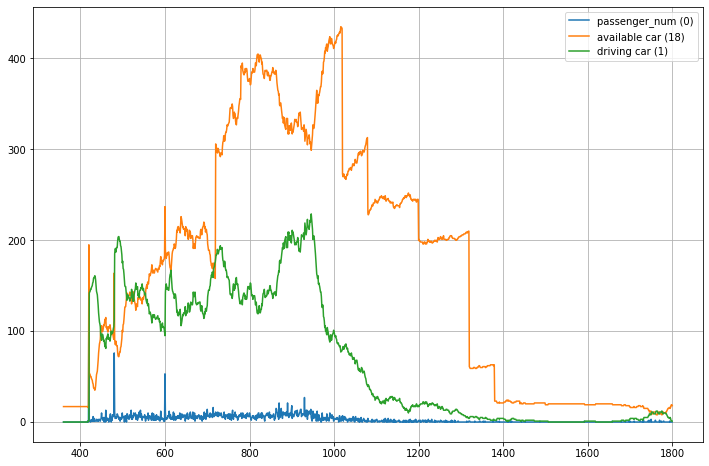

In [15]:
empty_taxi = pd.DataFrame()
driving_data = pd.DataFrame()
taxi_statistics_information = pd.DataFrame()
ps_remain = []
trips = []
empty_inf = []

####시각화 dummy var
a = [] #대기 고객
b = [] #배차 가능 차량 
c = [] #운행 중인 차량
x = [] #시간
####

for i in range(6*60, 30*60+1):
    clear_output(True)
    #운행종료 택시 제거
    if (i % 60 == 0) and (i != 360):
        empty_taxi = empty_taxi.loc[empty_taxi.work_end >= i]

    if i % 60 == 0:
        #운행 시작 택시
        start_taxi = taxi_locations.loc[taxi_locations.work_start == i]
        #배차 안된 택시
        empty_taxi = pd.concat([start_taxi, empty_taxi])
    #택시 콜한 고객
    call_ps = passenger_locations.loc[passenger_locations.call_time == i]
    #빈 차량 정보
    empty_inf.append([i,empty_taxi])
    
    ###
    a.extend([len(call_ps) + len(ps_remain)])
    b.extend([len(empty_taxi)])
    c.extend([len(driving_data)])
    x.extend([i])
    
    plt.figure(figsize=(12, 8))
    plt.rcParams['axes.grid'] = True 
    plt.plot(x,a, label = f"passenger_num ({len(call_ps) + len(ps_remain)})")
    plt.plot(x,b, label = f"available car ({len(empty_taxi)})")
    plt.plot(x,c, label = f"driving car ({len(driving_data)})")
    plt.legend()
    plt.show()
    ###
    if len(call_ps) + len(ps_remain) > 0:
        if len(ps_remain) > 0:            
            trip, driving, ps_remain, tx_remain, taxi_statistics_inf, passenger_loc_inf = match_taxi_ps(ps_remain, empty_taxi)
            taxi_statistics_information = pd.concat([taxi_statistics_information,taxi_statistics_inf])
            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            passenger_loc_information.append(passenger_loc_inf)
            trips.extend(trip)
            
            if len(ps_remain) > 0:
                ps_remain = pd.concat([ps_remain, call_ps])
        
        if len(ps_remain) == 0:
            trip, driving, ps_remain, tx_remain, taxi_statistics_inf, passenger_loc_inf = match_taxi_ps(call_ps, empty_taxi)
            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            taxi_statistics_information = pd.concat([taxi_statistics_information,taxi_statistics_inf])
            passenger_loc_information.append(passenger_loc_inf)
            trips.extend(trip)
    
    if len(driving_data) > 0:
        #################
        #운행 종료 택시
        drive_end = driving_data.loc[driving_data["end_time"] <= i]
        drive_end = drive_end[["no","cartype","work_start","work_end","board_status","tx_loc"]]
        #운행 중인 택시
        driving_data = driving_data.loc[driving_data["end_time"] > i]
        #운행 종료 후 택시 빈 택시에 추가
        empty_taxi = pd.concat([empty_taxi ,drive_end])
        
ps_loc_inf = pd.concat(passenger_loc_information)
ps_loc_inf = [{"path":[i[1]["loc"].x, i[1]["loc"].y], "timestamp":i[1]["time"]} for i in ps_loc_inf.iterrows()]        
stop_taxi = pd.concat(list(map(lambda data: stop_taxi_inf(data), empty_inf)))
empty_inf = list(map(lambda data : generate_taxi_pull_over_inf(data[1]) ,stop_taxi.groupby("no")))
empty_inf = list(itertools.chain(*empty_inf))
ps_final_inf, taxi_final_inf = generate_drive_inf(taxi_locations, taxi_statistics_information)

In [16]:
file_path = "empty.json"

with open(file_path, "w") as f:
    json.dump(empty_inf, f)

In [17]:
file_path = "trips.json"

with open(file_path, "w") as f:
    json.dump(trips, f)

In [18]:
file_path = "ps_loc_inf.json"

with open(file_path, "w") as f:
    json.dump(ps_loc_inf, f)